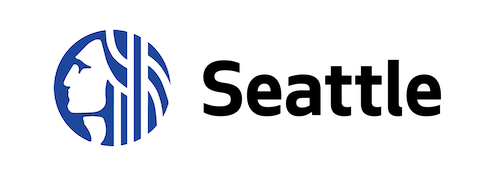


<h1><center> NOTEBOOK D'EXPLORATION 
   

Objectif : vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation.

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
#import file
benchmark=pd.read_csv("2016_Building_Energy_Benchmarking.csv")

In [3]:
benchmark.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [4]:
benchmark.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

Les colonnes ci dessous correspondent toutes à des mesures de l'énergie consommée des bâtiments. 
Nous allons utiliser pour les prévisions la colonne SiteEnergyUseWN(kBtu) qui correspond au montant annuel d'energie consommée par la propriété toutes sources d'énergies confondues ajustée des données météorologique.

SiteEUI(kBtu/sf)                
SiteEUIWN(kBtu/sf)              
SourceEUI(kBtu/sf)              
SourceEUIWN(kBtu/sf)             
**SiteEnergyUse(kBtu)**              
**SiteEnergyUseWN(kBtu)** 

Les colonnes ci dessous qui détaillent la consommation  par les sources d'énergie en différentes unités, nous allons garder uniquement celles en kBtu pour être cohérent avec la colonne SiteEnergyUse(kBtu) et calculer les proportion de chaque source d'énergie.

**SteamUse(kBtu)**                   
Electricity(kWh)                 
**Electricity(kBtu)**                
NaturalGas(therms)               
**NaturalGas(kBtu)**           

De même il y a deux colonnes relatives aux émissions de C02, nous allons uniquement garder la colonne TotalGHGEmissions.
TotalGHGEmissions                
GHGEmissionsIntensity     

Les colonnes 'Comments','Outlier', 'YearsENERGYSTARCertified', 'DefaultData', 'ComplianceStatus' sont insuffisament renseignées et ne correspondent pas à notre objectif de se baser sur les données structurelles du bâtiment, nous n'allons pas les conserver. 


In [5]:
#liste des colonnes à supprimer
col_todrop=(['GHGEmissionsIntensity', 'YearsENERGYSTARCertified','Electricity(kWh)', 'NaturalGas(therms)']
            +list(benchmark.columns[29:33])
            +list(benchmark.columns[40:44]))
           
col_todrop

['GHGEmissionsIntensity',
 'YearsENERGYSTARCertified',
 'Electricity(kWh)',
 'NaturalGas(therms)',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'DefaultData',
 'Comments',
 'ComplianceStatus',
 'Outlier']

In [6]:
#supression des colonnes 
benchmark.drop(labels=col_todrop, axis=1, inplace=True)

Notre objectif est de se concentrer sur les bâtiments non résidentiels, nous allons donc créer un data frame incluant uniquement ces bâtiments

In [7]:
benchmark['BuildingType'].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [8]:
#data_frame contenant les bâtiments non-résidentiels
benchmark_NR=benchmark.loc[benchmark['BuildingType'].isin(['NonResidential',
                                                          'SPS-District K-12',
                                                          'Nonresidential COS',
                                                          'Campus',
                                                          'Nonresidential WA']
                                                         )]

In [9]:
benchmark_NR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1668 entries, 0 to 3375
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1668 non-null   int64  
 1   DataYear                         1668 non-null   int64  
 2   BuildingType                     1668 non-null   object 
 3   PrimaryPropertyType              1668 non-null   object 
 4   PropertyName                     1668 non-null   object 
 5   Address                          1668 non-null   object 
 6   City                             1668 non-null   object 
 7   State                            1668 non-null   object 
 8   ZipCode                          1652 non-null   float64
 9   TaxParcelIdentificationNumber    1668 non-null   object 
 10  CouncilDistrictCode              1668 non-null   int64  
 11  Neighborhood                     1668 non-null   object 
 12  Latitude            

In [10]:
#gardons uniquement les lignes ou nous avons une estimation de la consommation d'énergie
benchmark_NR=benchmark_NR.loc[benchmark_NR['SiteEnergyUseWN(kBtu)'].notnull()].reset_index(drop=True)

Nous allons utiliser les colonnes ci dessous pour estimer les proportion d'energie utilisée par source.

SteamUse(kBtu)                                 
Electricity(kBtu)                              
NaturalGas(kBtu)   

In [11]:
benchmark_NR.loc[benchmark_NR['SiteEnergyUse(kBtu)']==0, ['SiteEnergyUse(kBtu)','SteamUse(kBtu)', 'Electricity(kBtu)','NaturalGas(kBtu)']]

,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
27,0.0,0.0,0.0,0.0
30,0.0,0.0,1496816.0,0.0
61,0.0,0.0,600813.0,0.0
80,0.0,0.0,1698176.0,0.0
84,0.0,0.0,2347138.0,0.0
94,0.0,0.0,2104286.0,0.0
132,0.0,0.0,0.0,4318917.0
138,0.0,0.0,0.0,3217877.0
151,0.0,0.0,0.0,0.0
298,0.0,0.0,0.0,0.0


Il y a des valeurs à zéro sur la colonne SiteEnergyUse alors que les colonnes Electricity et NaturalGas sont parfois renseignées.
Nous allons remplacer la colonne SiteEnergyUse par les valeurs Electricity et Natural Gas lorsqu'elles sont renseignées

In [12]:
benchmark_NR.loc[benchmark_NR['SiteEnergyUse(kBtu)']==0, 'SiteEnergyUse(kBtu)']=benchmark_NR.loc[benchmark_NR['SiteEnergyUse(kBtu)']==0,
                                                                                                 ['Electricity(kBtu)','NaturalGas(kBtu)']].sum(axis=1)

In [13]:
benchmark_NR.loc[:,'SteamUse(%)']=benchmark_NR.loc[:,'SteamUse(kBtu)']/benchmark_NR.loc[:,'SiteEnergyUse(kBtu)']*100

In [14]:
benchmark_NR['Electricity(%)']=benchmark_NR['Electricity(kBtu)']/benchmark_NR['SiteEnergyUse(kBtu)']*100

In [15]:
benchmark_NR['NaturalGas(%)']=benchmark_NR['NaturalGas(kBtu)']/benchmark_NR['SiteEnergyUse(kBtu)']*100

In [16]:
benchmark_NR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1665 non-null   int64  
 1   DataYear                         1665 non-null   int64  
 2   BuildingType                     1665 non-null   object 
 3   PrimaryPropertyType              1665 non-null   object 
 4   PropertyName                     1665 non-null   object 
 5   Address                          1665 non-null   object 
 6   City                             1665 non-null   object 
 7   State                            1665 non-null   object 
 8   ZipCode                          1649 non-null   float64
 9   TaxParcelIdentificationNumber    1665 non-null   object 
 10  CouncilDistrictCode              1665 non-null   int64  
 11  Neighborhood                     1665 non-null   object 
 12  Latitude            

In [17]:
benchmark_NR.loc[benchmark_NR['SteamUse(%)'].isna(), ['SiteEnergyUse(kBtu)','SteamUse(kBtu)', 'Electricity(kBtu)','NaturalGas(kBtu)']]

,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
27,0.0,0.0,0.0,0.0
151,0.0,0.0,0.0,0.0
298,0.0,0.0,0.0,0.0
665,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,0.0


Remplacement des valeurs nulles

In [18]:
benchmark_NR.loc[benchmark_NR['LargestPropertyUseTypeGFA'].isnull(),'LargestPropertyUseTypeGFA']=benchmark_NR.loc[benchmark_NR['LargestPropertyUseTypeGFA'].isnull(),'PropertyGFABuilding(s)']

In [19]:
benchmark_NR.loc[benchmark_NR['LargestPropertyUseType'].isnull(),'LargestPropertyUseType']='PrimaryPropertyType'

In [20]:
for col in ['SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA','SteamUse(%)','Electricity(%)','NaturalGas(%)']:
    benchmark_NR.loc[:,col].fillna(0, inplace=True)

In [21]:
for col in ['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']:
    benchmark_NR.loc[:,col].fillna('None', inplace=True)

In [22]:
#supression des colonnes 
benchmark_NR.drop(labels='SiteEnergyUse(kBtu)', axis=1, inplace=True)

In [23]:
benchmark_NR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1665 non-null   int64  
 1   DataYear                         1665 non-null   int64  
 2   BuildingType                     1665 non-null   object 
 3   PrimaryPropertyType              1665 non-null   object 
 4   PropertyName                     1665 non-null   object 
 5   Address                          1665 non-null   object 
 6   City                             1665 non-null   object 
 7   State                            1665 non-null   object 
 8   ZipCode                          1649 non-null   float64
 9   TaxParcelIdentificationNumber    1665 non-null   object 
 10  CouncilDistrictCode              1665 non-null   int64  
 11  Neighborhood                     1665 non-null   object 
 12  Latitude            

Analyse exploratoire des variables

In [24]:
#statistiques descriptives des colonnes numériques
benchmark_NR.describe().T[7:]

,count,mean,std,min,25%,50%,75%,max
NumberofBuildings,1665.0,1.168769e+00,2.932286e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.110000e+02
NumberofFloors,1665.0,4.120721e+00,6.568735e+00,0.000000,1.000000e+00,2.000000e+00,4.000000e+00,9.900000e+01
PropertyGFATotal,1665.0,1.189277e+05,2.976171e+05,11285.000000,2.949800e+04,4.928000e+04,1.051000e+05,9.320156e+06
PropertyGFAParking,1665.0,1.286887e+04,4.227105e+04,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.126080e+05
PropertyGFABuilding(s),1665.0,1.060588e+05,2.844540e+05,3636.000000,2.849200e+04,4.741500e+04,9.490000e+04,9.320156e+06
LargestPropertyUseTypeGFA,1665.0,9.866485e+04,2.764707e+05,5656.000000,2.554700e+04,4.381300e+04,9.193500e+04,9.320156e+06
SecondLargestPropertyUseTypeGFA,1665.0,1.889292e+04,5.331460e+04,0.000000,0.000000e+00,0.000000e+00,1.268900e+04,6.867500e+05
ThirdLargestPropertyUseTypeGFA,1665.0,3.163885e+03,1.798761e+04,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.597480e+05
ENERGYSTARScore,1093.0,6.542452e+01,2.849377e+01,1.000000,4.800000e+01,7.300000e+01,8.900000e+01,1.000000e+02
SiteEnergyUseWN(kBtu),1665.0,8.064790e+06,2.203878e+07,0.000000,1.294615e+06,2.685146e+06,7.109712e+06,4.716139e+08


In [25]:
#suppression des consommations d'énergie négatives
benchmark_NR.drop(benchmark_NR.loc[benchmark_NR['Electricity(kBtu)']<0].index, inplace=True)

<AxesSubplot:>

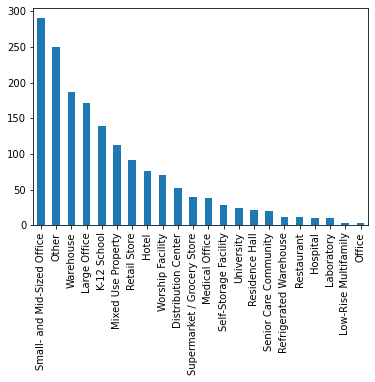

In [26]:
benchmark_NR['PrimaryPropertyType'].value_counts().plot(kind='bar')

In [27]:
benchmark_NR['CouncilDistrictCode'].value_counts()

7    527
2    397
3    202
4    172
5    132
1    119
6    115
Name: CouncilDistrictCode, dtype: int64

In [28]:
#harmonisation des formats
benchmark_NR['Neighborhood']=benchmark_NR['Neighborhood'].str.upper()

In [29]:
#harmonisation des noms
benchmark_NR['Neighborhood']=benchmark_NR['Neighborhood'].str.replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')

In [30]:
benchmark_NR['Neighborhood'].value_counts()

DOWNTOWN                 359
GREATER DUWAMISH         346
MAGNOLIA / QUEEN ANNE    151
LAKE UNION               148
NORTHEAST                127
EAST                     121
NORTHWEST                 86
BALLARD                   70
NORTH                     67
CENTRAL                   55
DELRIDGE                  47
SOUTHEAST                 46
SOUTHWEST                 41
Name: Neighborhood, dtype: int64

<AxesSubplot:>

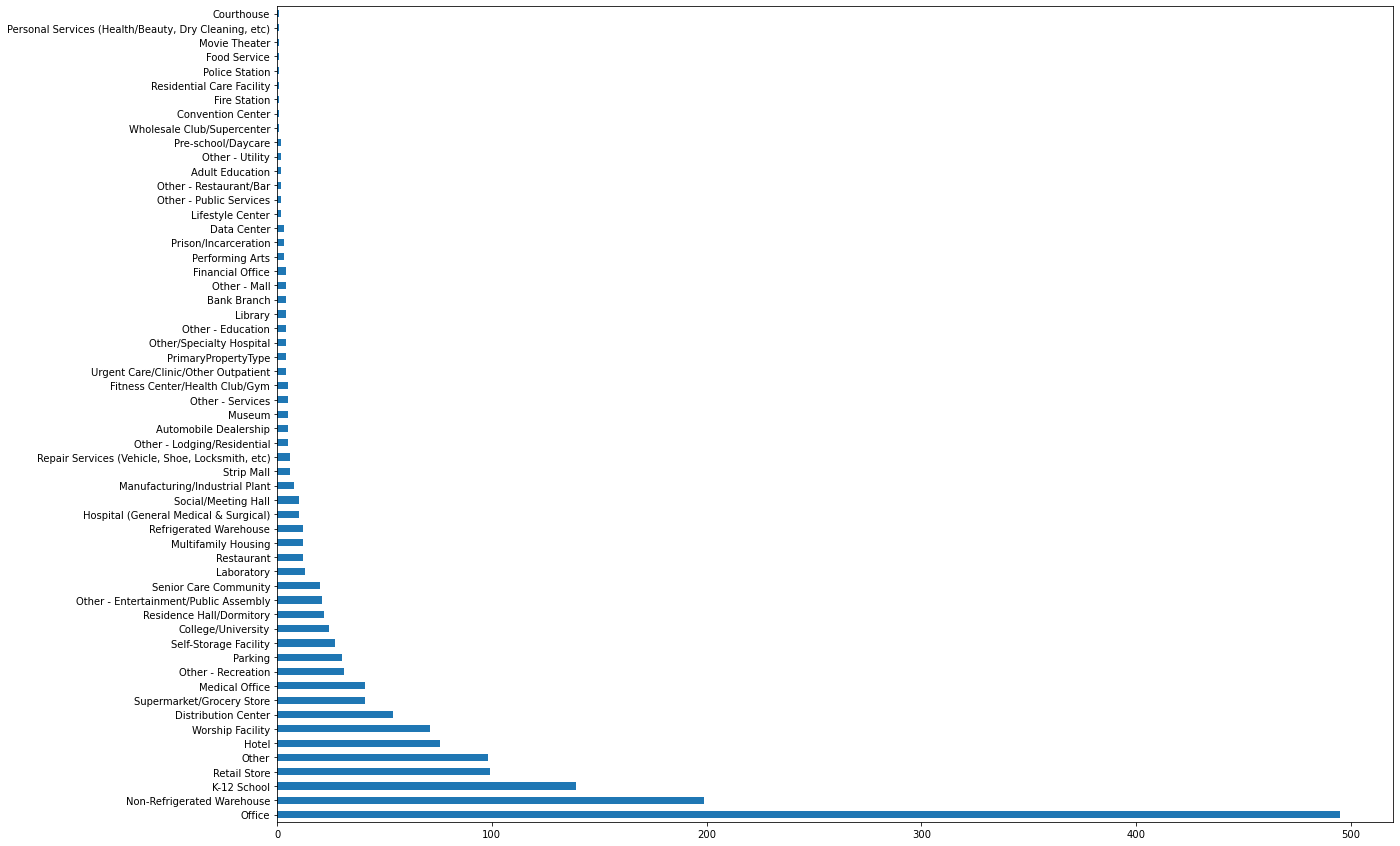

In [31]:
fig1, ax =plt.subplots(figsize=(20,15))
benchmark_NR['LargestPropertyUseType'].value_counts().plot(kind='barh')

In [32]:
len(benchmark_NR['LargestPropertyUseType'].unique())

57

Il y 57 valeurs différentes, nous allons regrouper toutes catégories qui compte moins de 10 building dans la catégorie Other

In [33]:
other_put=list(benchmark_NR['LargestPropertyUseType'].value_counts().loc[benchmark_NR['LargestPropertyUseType'].value_counts()<10].index)

In [34]:
benchmark_NR.loc[benchmark_NR['LargestPropertyUseType'].isin(other_put), 'LargestPropertyUseType' ]=benchmark_NR.loc[benchmark_NR['LargestPropertyUseType'].isin(other_put), 'LargestPropertyUseType' ].apply(lambda x : x.replace(x,'Other'))

In [35]:
len(benchmark_NR['LargestPropertyUseType'].unique())

23

In [36]:
benchmark_NR.loc[benchmark_NR['SecondLargestPropertyUseType'].isin(other_put), 'SecondLargestPropertyUseType' ]=benchmark_NR.loc[benchmark_NR['SecondLargestPropertyUseType'].isin(other_put), 'SecondLargestPropertyUseType' ].apply(lambda x : x.replace(x,'Other'))

In [37]:
len(benchmark_NR['SecondLargestPropertyUseType'].unique())

29

In [38]:
other_sput=list(set(benchmark_NR['SecondLargestPropertyUseType'].value_counts().index)-set(benchmark_NR['LargestPropertyUseType'].value_counts().index))
other_sput.remove('None')

In [39]:
benchmark_NR.loc[benchmark_NR['SecondLargestPropertyUseType'].isin(other_sput), 'SecondLargestPropertyUseType' ]=benchmark_NR.loc[benchmark_NR['SecondLargestPropertyUseType'].isin(other_sput), 'SecondLargestPropertyUseType' ].apply(lambda x : x.replace(x,'Other'))

In [40]:
benchmark_NR.loc[benchmark_NR['ThirdLargestPropertyUseType'].isin(other_put+other_sput), 'ThirdLargestPropertyUseType' ]=benchmark_NR.loc[benchmark_NR['ThirdLargestPropertyUseType'].isin(other_put+other_sput), 'ThirdLargestPropertyUseType' ].apply(lambda x : x.replace(x,'Other'))

In [41]:
len(benchmark_NR['ThirdLargestPropertyUseType'].unique())

22

In [42]:
set(benchmark_NR['ThirdLargestPropertyUseType'].value_counts().index)-set(benchmark_NR['SecondLargestPropertyUseType'].value_counts().index)

{'Fast Food Restaurant', 'Other - Technology/Science'}

In [43]:
benchmark_NR.loc[benchmark_NR['ThirdLargestPropertyUseType'].isin(['Fast Food Restaurant', 'Other - Technology/Science']), 'ThirdLargestPropertyUseType' ]=benchmark_NR.loc[benchmark_NR['ThirdLargestPropertyUseType'].isin(['Fast Food Restaurant', 'Other - Technology/Science']), 'ThirdLargestPropertyUseType' ].apply(lambda x : x.replace(x,'Other'))

<AxesSubplot:>

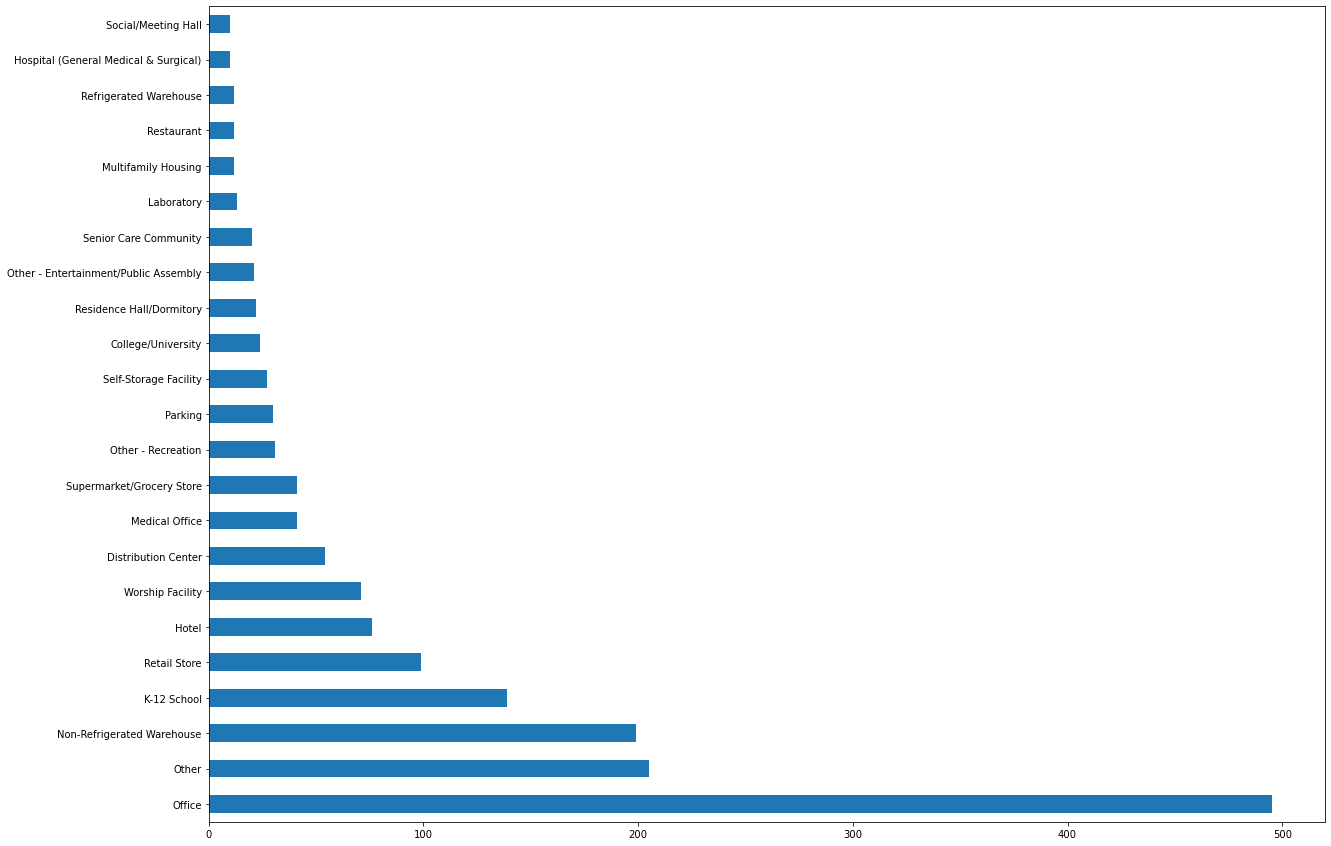

In [44]:
fig1, ax =plt.subplots(figsize=(20,15))
benchmark_NR['LargestPropertyUseType'].value_counts().plot(kind='barh')

<AxesSubplot:>

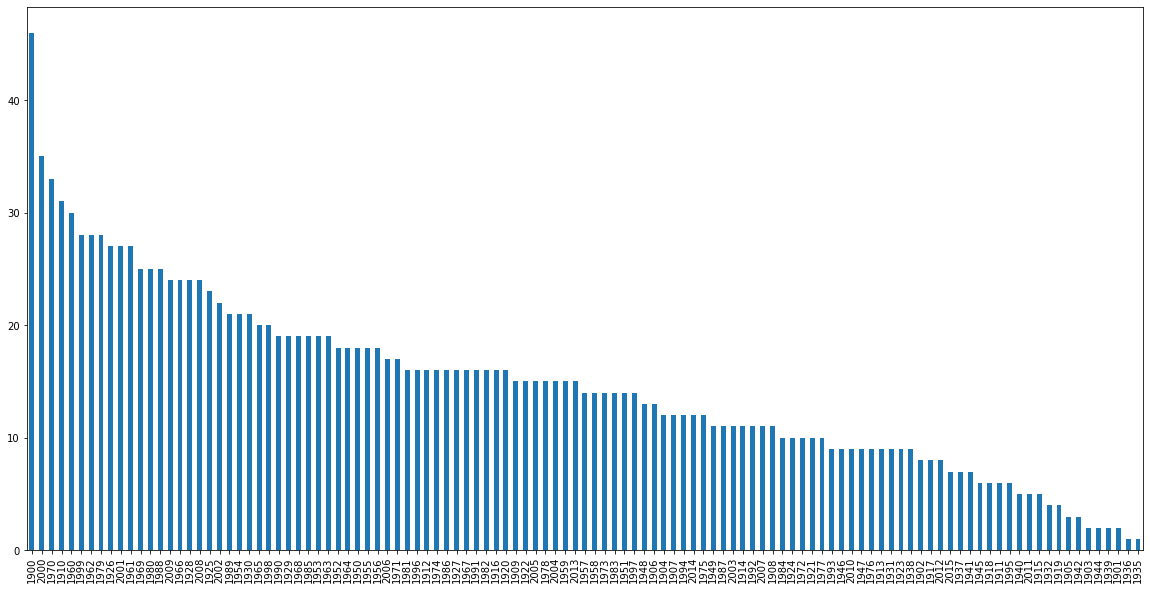

In [45]:
fig1, ax =plt.subplots(figsize=(20,10))
benchmark_NR['YearBuilt'].value_counts().plot(kind='bar')


<AxesSubplot:xlabel='PropertyGFATotal', ylabel='Percent'>

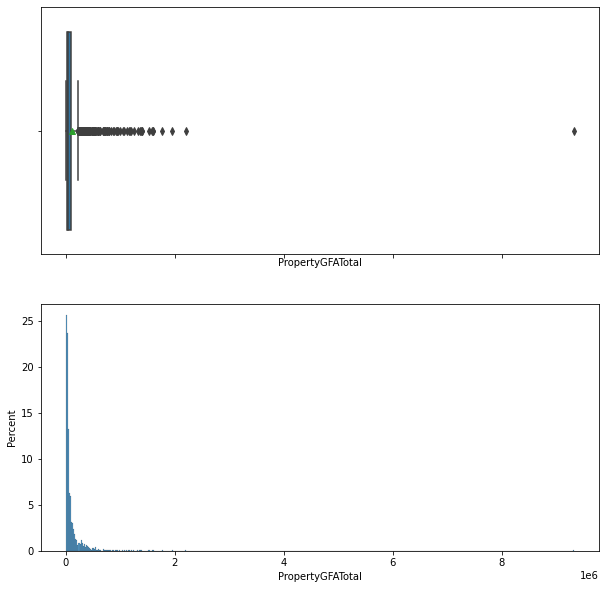

In [46]:
fig1, (ax1,ax2) =plt.subplots(2,1,figsize=(10,10), sharex=True)
sns.boxplot(x=benchmark_NR['PropertyGFATotal'],showmeans=True, ax=ax1)
sns.histplot(benchmark_NR['PropertyGFATotal'], stat='percent', bins=500)

#ax1.set_xlim(0,500000)

In [47]:
benchmark_NR[['PropertyGFATotal','PrimaryPropertyType']].sort_values('PropertyGFATotal', ascending=False).head()

,PropertyGFATotal,PrimaryPropertyType
1624,9320156,University
981,2200000,University
549,1952220,Large Office
606,1765970,Hospital
286,1605578,Large Office


<AxesSubplot:xlabel='PropertyGFABuilding(s)', ylabel='Percent'>

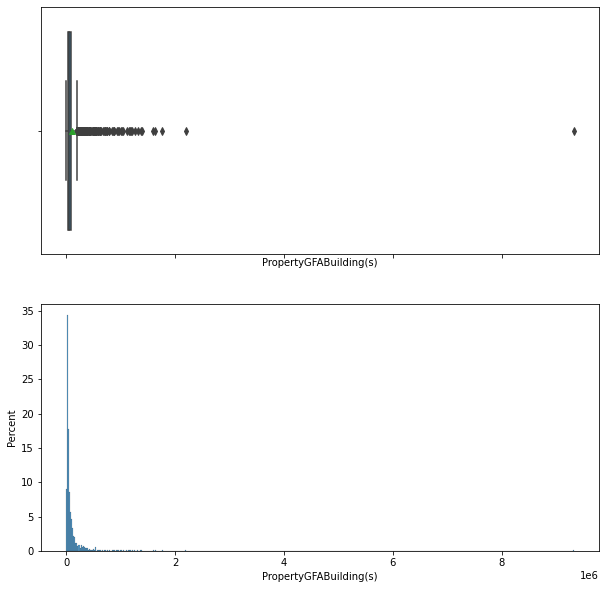

In [48]:
fig1, (ax1,ax2) =plt.subplots(2,1,figsize=(10,10), sharex=True)
sns.boxplot(x=benchmark_NR['PropertyGFABuilding(s)'],showmeans=True, ax=ax1)
sns.histplot(benchmark_NR['PropertyGFABuilding(s)'], stat='percent', bins=500)

#ax1.set_xlim(0,500000)

<AxesSubplot:xlabel='PropertyGFAParking', ylabel='Percent'>

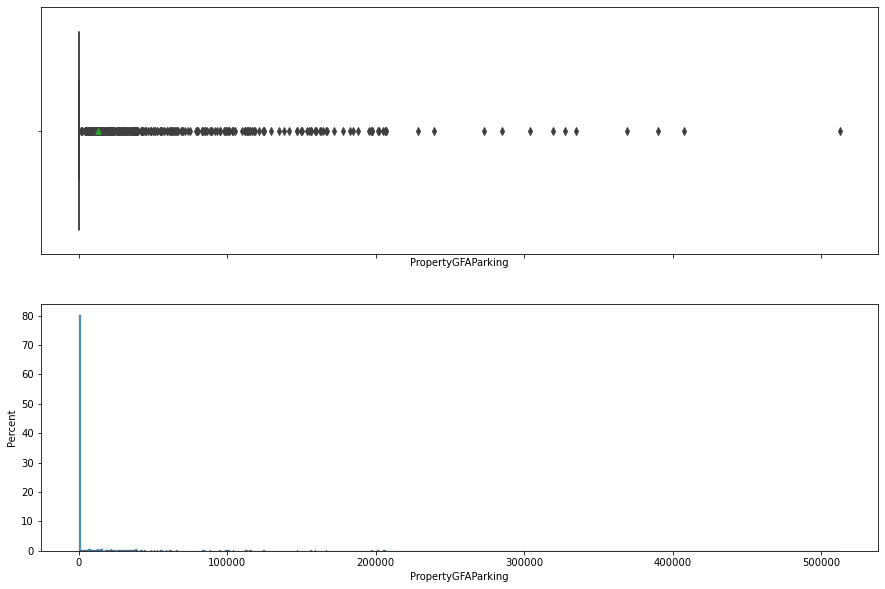

In [49]:
fig1, (ax1,ax2) =plt.subplots(2,1,figsize=(15,10), sharex=True)
sns.boxplot(x=benchmark_NR['PropertyGFAParking'],showmeans=True, ax=ax1)
sns.histplot(benchmark_NR['PropertyGFAParking'], stat='percent', bins=500)

#ax1.set_xlim(0,500000)

<AxesSubplot:xlabel='SiteEnergyUseWN(kBtu)', ylabel='Percent'>

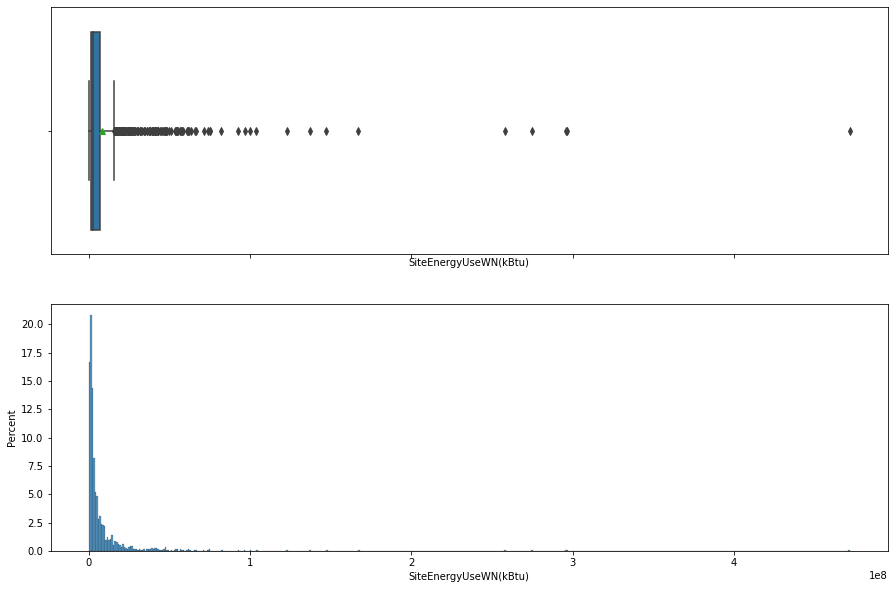

In [50]:
fig1, (ax1,ax2) =plt.subplots(2,1,figsize=(15,10), sharex=True)
sns.boxplot(x=benchmark_NR['SiteEnergyUseWN(kBtu)'],showmeans=True, ax=ax1)
sns.histplot(benchmark_NR['SiteEnergyUseWN(kBtu)'], stat='percent', bins=500)

#ax1.set_xlim(0,50000000)

<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Percent'>

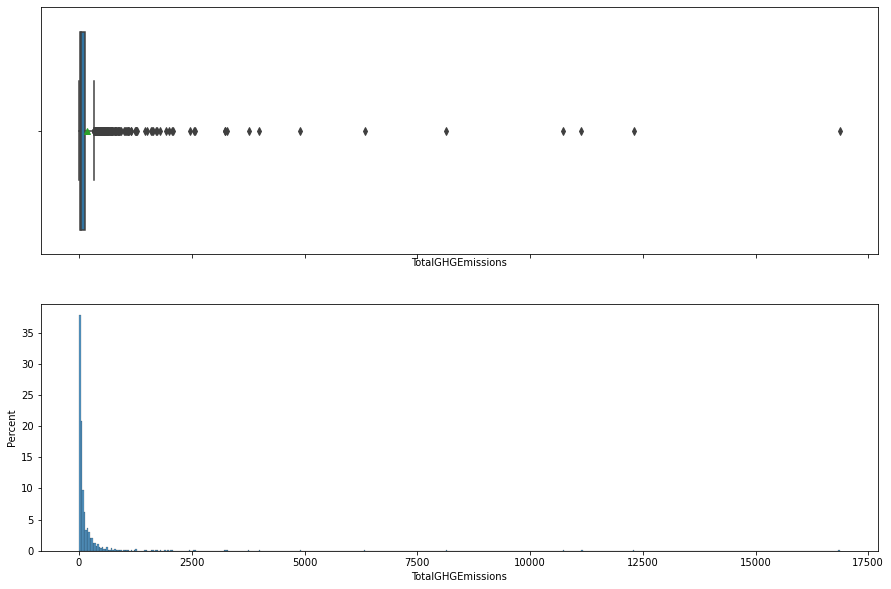

In [51]:
fig1, (ax1,ax2) =plt.subplots(2,1,figsize=(15,10), sharex=True)
sns.boxplot(x=benchmark_NR['TotalGHGEmissions'],showmeans=True, ax=ax1)
sns.histplot(benchmark_NR['TotalGHGEmissions'], stat='percent', bins=500)

#ax1.set_xlim(0,50000000)

<AxesSubplot:ylabel='Percent'>

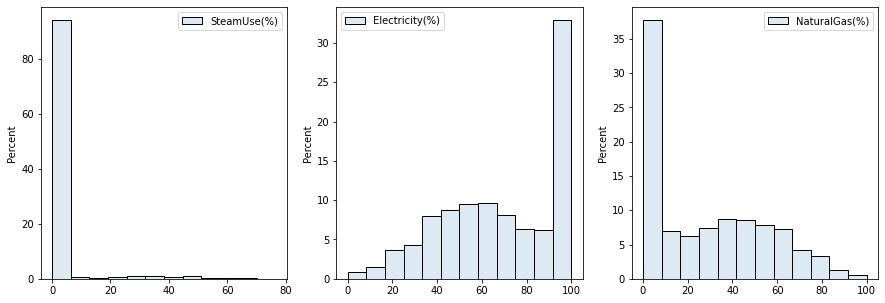

In [52]:
fig1,  (ax1,ax2,ax3) =plt.subplots(1,3,figsize=(15,5))

sns.histplot(data=benchmark_NR[["SteamUse(%)"]], ax=ax1, alpha=0.15, stat='percent')
sns.histplot(data=benchmark_NR[["Electricity(%)"]], ax=ax2, alpha=0.15, stat='percent')
sns.histplot(data=benchmark_NR[["NaturalGas(%)"]], ax=ax3, alpha=0.15, stat='percent')

<AxesSubplot:>

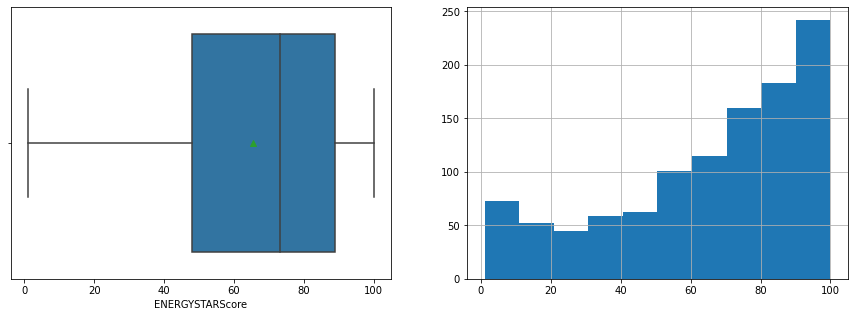

In [53]:
fig1, (ax1,ax2) =plt.subplots(1,2,figsize=(15,5))
sns.boxplot(x=benchmark_NR['ENERGYSTARScore'],showmeans=True, ax=ax1)
benchmark_NR['ENERGYSTARScore'].hist()

In [54]:
#calculons l'ancienneté des bâtiments
benchmark_NR['Age']=2016-benchmark_NR['YearBuilt']

In [55]:
benchmark_NR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1664 entries, 0 to 1664
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1664 non-null   int64  
 1   DataYear                         1664 non-null   int64  
 2   BuildingType                     1664 non-null   object 
 3   PrimaryPropertyType              1664 non-null   object 
 4   PropertyName                     1664 non-null   object 
 5   Address                          1664 non-null   object 
 6   City                             1664 non-null   object 
 7   State                            1664 non-null   object 
 8   ZipCode                          1648 non-null   float64
 9   TaxParcelIdentificationNumber    1664 non-null   object 
 10  CouncilDistrictCode              1664 non-null   int64  
 11  Neighborhood                     1664 non-null   object 
 12  Latitude            

In [56]:
#Export fichier final
benchmark_NR.to_csv('benchmark_NR.csv', index=False)